<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Loading-Images" data-toc-modified-id="Loading-Images-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading Images</a></span></li><li><span><a href="#Data-PreProcessing-Image" data-toc-modified-id="Data-PreProcessing-Image-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data PreProcessing Image</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Hyperparameter-Tuning" data-toc-modified-id="Hyperparameter-Tuning-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Hyperparameter Tuning</a></span></li><li><span><a href="#Content-Loss" data-toc-modified-id="Content-Loss-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Content Loss</a></span></li><li><span><a href="#Style-Loss" data-toc-modified-id="Style-Loss-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Style Loss</a></span></li><li><span><a href="#Style-Transfer-Process" data-toc-modified-id="Style-Transfer-Process-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Style Transfer Process</a></span></li><li><span><a href="#Result" data-toc-modified-id="Result-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Result</a></span></li></ul></div>

# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import PIL.Image
from PIL import Image
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import cv2
from skimage.io import imread_collection

from keras.models import model_from_json

# Loading Images

In [2]:
original_img_path = r"D:\Style-Transfer\Webscrape\dataset\images\content_images\players\lewis hamliton22.jpg"
style_img_path = r"D:\Style-Transfer\Webscrape\dataset\images\style_images\PABLO PICASSO\PABLO PICASSO paintings65.jpg"

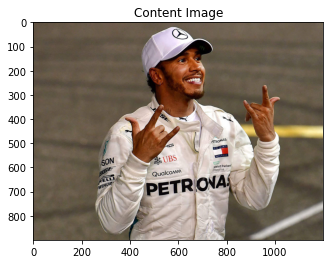

In [3]:
original_img = cv2.imread(original_img_path, cv2.IMREAD_UNCHANGED)
plt.imshow(original_img[...,::-1])    # cv keeps the images in BGR
plt.title('Content Image')
plt.show()

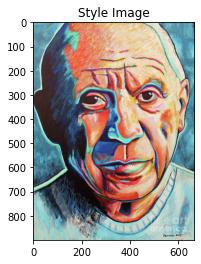

In [5]:
style_img = cv2.imread(style_img_path, cv2.IMREAD_UNCHANGED)
plt.imshow(style_img[...,::-1])    # cv keeps the images in BGR
plt.title('Style Image')
plt.show()

In [6]:
original_img.shape

(900, 1200, 3)

In [7]:
style_img.shape

(900, 667, 3)

# Data PreProcessing Image

Data Preprocessing of Image done from Data Preprocessing Directory

In [8]:
original_img_processed = PIL.Image.open("lewis hamliton22_processed.jpg").convert('RGB')
style_img_processed = PIL.Image.open("PABLO PICASSO paintings65_processed.jpg").convert('RGB')

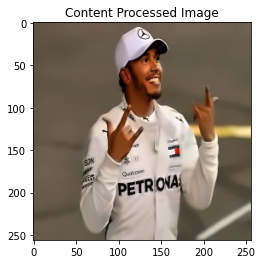

In [9]:
im_array1 = np.asarray(original_img_processed)
plt.imshow(im_array1)
plt.title('Content Processed Image')
plt.show()

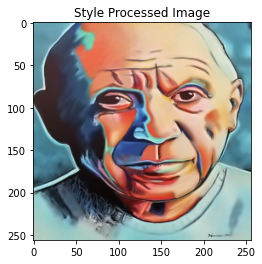

In [10]:
im_array2 = np.asarray(style_img_processed)
plt.imshow(im_array2)
plt.title('Style Processed Image')
plt.show()

In [11]:
original_img_processed.size

(256, 256)

In [12]:
style_img_processed.size

(256, 256)

In [13]:
print(torch.cuda.is_available())

True


In [14]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
image_size = 256

In [15]:
loader = transforms.Compose(
[
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

In [16]:
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [17]:
original_img_processed = load_image('lewis hamliton22_processed.jpg')
style_img_processed = load_image('PABLO PICASSO paintings65_processed.jpg')

# Model

In [18]:
model = models.vgg16(pretrained=True).features

In [19]:
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [20]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        self.chosen_features = ['0', '5', '10', '17', '24']
        self.model = models.vgg16(pretrained=True).features[:25]
    
    def forward(self, x):
        features = []
        
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            
            if str(layer_num) in self.chosen_features:
                features.append(x)
                
        return features
            

In [21]:
#freeze the weights
model = VGG().to(device).eval()

In [22]:
generated = original_img_processed.clone().requires_grad_(True)

# Hyperparameter Tuning

In [23]:
#Hyperparameters
total_steps = 2000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.RMSprop([generated], lr = learning_rate)

# Content Loss

In [24]:
def contentloss(gen_feature, orig_feature):
    value = torch.mean((gen_feature - orig_feature)**2)
    return value

# Style Loss

In [25]:
def styleloss(G, A):
    value = torch.mean((G - A)**2)
    return value

# Style Transfer Process

In [26]:
for step in range(total_steps+1):
    generated_features = model(generated)
    original_img_features = model(original_img_processed)
    style_features = model(style_img_processed)
    
    style_loss = original_loss = 0
    
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):
        batch_size, channel, height, width = gen_feature.shape
        #Content loss
        original_loss += contentloss(gen_feature, orig_feature)
        
        #compte Gram matrix
        G = gen_feature.view(channel, height*width).mm(
            gen_feature.view(channel, height*width).t()
        )
        
        A = style_feature.view(channel, height*width).mm(
            style_feature.view(channel, height*width).t()
        )
        
        #Style Loss
        style_loss += styleloss(G, A)
        
    total_loss = alpha*original_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if step%100 == 0:
        print("Step - {} => Total Loss - {}".format(step,total_loss))
    if step % 2000 == 0 and step != 0:
        print("Final total loss = {}".format(total_loss))
        save_image(generated, "generated_lewis hamliton22_PABLO PICASSO paintings65.png")

Step - 0 => Total Loss - 173559.59375
Step - 100 => Total Loss - 18418.466796875
Step - 200 => Total Loss - 13313.478515625
Step - 300 => Total Loss - 11300.15625
Step - 400 => Total Loss - 9686.58984375
Step - 500 => Total Loss - 7854.2802734375
Step - 600 => Total Loss - 6982.70751953125
Step - 700 => Total Loss - 6388.876953125
Step - 800 => Total Loss - 5907.8134765625
Step - 900 => Total Loss - 5544.85302734375
Step - 1000 => Total Loss - 5224.82958984375
Step - 1100 => Total Loss - 5171.87109375
Step - 1200 => Total Loss - 4703.7880859375
Step - 1300 => Total Loss - 4621.6181640625
Step - 1400 => Total Loss - 4307.46142578125
Step - 1500 => Total Loss - 4332.884765625
Step - 1600 => Total Loss - 4157.99267578125
Step - 1700 => Total Loss - 4092.135009765625
Step - 1800 => Total Loss - 3742.141357421875
Step - 1900 => Total Loss - 3890.554931640625
Step - 2000 => Total Loss - 3503.93017578125
Final total loss = 3503.93017578125


# Result

In [27]:
generated_img = PIL.Image.open("generated_lewis hamliton22_PABLO PICASSO paintings65.png").convert('RGB')

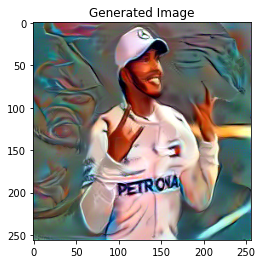

In [28]:
im_array1 = np.asarray(generated_img)
plt.imshow(im_array1)
plt.title('Generated Image')
plt.show()

In [29]:
generated_img.size

(256, 256)